In [37]:
# if you run this local

import os
if os.getcwd()[-10:] != "happywhale":
    os.chdir("..")

In [38]:
# if you run this online (i.e. Colab)

# !git clone https://github.com/louiskhub/happywhale.git
# %cd happywhale

In [39]:
#@title Imports, Downloading + cleaning data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorboard as tb
from scipy.interpolate import interp1d

experiment_id =  "Kw5MjM86SbawD9jbd6lsPw"
experiment = tb.data.experimental.ExperimentFromDev(experiment_id)
df = experiment.get_scalars()

df = df[df["tag"].apply(lambda x : "iter" not  in x)]

def concat_data(df, data_order):
  earlier,later = data_order
  late_indexes = df[df["run"].apply(lambda x: later in x)].index
  earlier_indexes = df[df["run"].apply(lambda x: earlier in x)].index

  max_epoch = df.loc[earlier_indexes,"step"].max() + 1

  df.loc[late_indexes,"step"] += max_epoch
  df.loc[earlier_indexes,"run"]= df.loc[earlier_indexes,"run"].apply(lambda x : x.replace(earlier,later))
  return df

df.loc[df["run"].apply(lambda x: "train" in x),"kind_of_training"]="train"
df.loc[df["run"].apply(lambda x: "val" in x),"kind_of_training"]="val"


first_run_speices_weights = ("121448/", "epoch-35")
df = concat_data(df, first_run_speices_weights)
second_run_speices_weights  = ("epoch-35","after epoch 39")
df = concat_data(df, second_run_speices_weights)

df["run"] = df["run"].apply(lambda run:run[:run.find("/")])

train_losses = {}


for model in df["run"].unique():
    train_loss = df[(df["run"]==model) * (df["kind_of_training"]=="train") * (df["tag"]=="epoch_loss")].sort_values("step")["value"].values    
    train_losses[model]= list(train_loss)

def cut_list(acc,cut_off_vals):
  if len(acc)>=cut_off_vals:
    return acc[:cut_off_vals]
  else:
    return acc + [None for i in range(len(acc),cut_off_vals)]

def smooth(y,cut_off_vals):
  y = y[:cut_off_vals]
  x = np.array(range(1,len(y)+1))
  cubic_interploation_model = interp1d(x, y, kind = "cubic")
  x = np.linspace(x.min(), x.max(), 10*len(x))
  y =cubic_interploation_model(x)
  return x,y

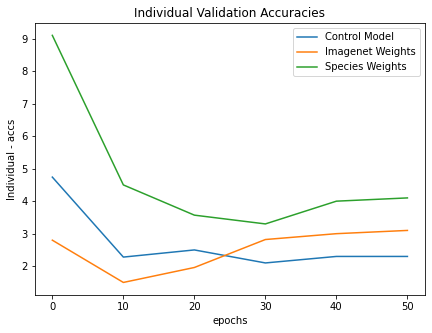

In [46]:
fig,ax = plt.subplots(figsize=(7, 5))
acc_epochs(ax,0,0)
ax.set_xlabel("epochs")
ax.set_ylabel("Individual - accs")
plt.legend()
plt.title("Individual Validation Accuracies")
plt.savefig("../../plot.png")

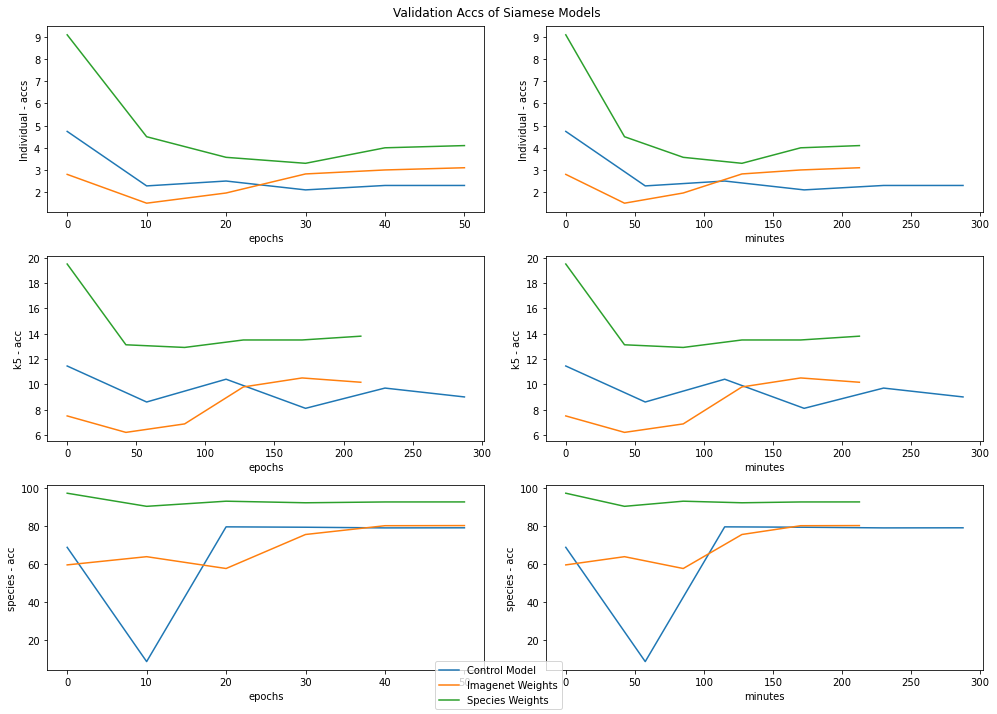

In [40]:
#@title Accuracies Losses of Siamese Networks

fig, ax = plt.subplots(3,2,figsize=(14, 10))
cut_off_vals = 200


inception_time = (60+25)/20
resnetv2_time = (60+55)/20


control = {0:(4.74,11.444,68.72),10:(2.28,8.60,8.6),20:(2.5,10.4,79.5),30:(2.1,8.1,79.3),40:(2.3,9.7,78.95),50:(2.3,9,79)}
imagenet = {0:(2.8,7.5,59.48),10:(1.5,6.2,63.8),20:(1.96,6.87,57.58),30:(2.82,9.79,75.48),40:(3,10.5,80.1),50:(3.1,10.16,80.17)}
species = {0:(9.1,19.5,97.2),10:(4.5,13.12,90.3),20:(3.57,12.91,93),30:(3.3,13.5,92.17),40:(4,13.5,92.6),50:(4.1,13.8,92.62)}

def acc_epochs(ax,j,time=0):
    for model in df["run"].unique():
      x = np.arange(0,51,10).astype(float)
      if "contr" in model:
        label = "Control Model"
        dic = control
        y = [dic[i][j] for i in x]
        factor=resnetv2_time 
      elif "image" in model:
        label = 'Imagenet Weights'
        dic = imagenet
        y = [dic[i][j] for i in x]
        factor=inception_time
      else: 
        label = 'Species Weights'
        dic = species
        y = [dic[i][j] for i in x]
        factor=inception_time
    
      if time:
        x*=factor
      ax.plot(x,y,label = label)

acc_epochs(ax[0,0],0,0)
ax[0,0].set_xlabel("epochs")
ax[0,0].set_ylabel("Individual - accs")


acc_epochs(ax[0,1],0,1)
ax[0,1].set_xlabel("minutes")
ax[0,1].set_ylabel("Individual - accs")


acc_epochs(ax[1,0],1,1)
ax[1,0].set_xlabel("epochs")
ax[1,0].set_ylabel("k5 - acc")

acc_epochs(ax[1,1],1,1)
ax[1,1].set_xlabel("minutes")
ax[1,1].set_ylabel("k5 - acc")



acc_epochs(ax[2,0],2)
ax[2,0].set_xlabel("epochs")
ax[2,0].set_ylabel("species - acc")

acc_epochs(ax[2,1],2,1)
ax[2,1].set_xlabel("minutes")
ax[2,1].set_ylabel("species - acc")
handles, labels = ax[2,1].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center')
fig.suptitle("Validation Accs of Siamese Models")
plt.tight_layout()
plt.show()

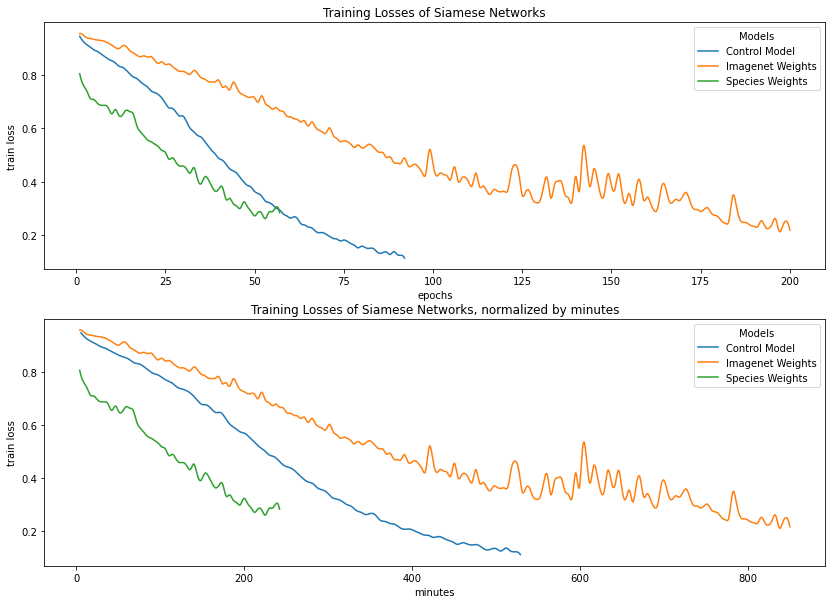

In [41]:
#@title Training Losses of Siamese Networks
fig, ax = plt.subplots(2,figsize=(14, 10))
cut_off_vals = 200
for model in df["run"].unique():
  if "contr" in model:
    label = "Control Model"
  elif "image" in model:
    label = 'Imagenet Weights'
  else: 
    label = 'Species Weights'

  x,y = smooth(train_losses[model],cut_off_vals)

  ax[0].plot(x,y,label = label)

ax[0].legend(title="Models")
ax[0].set_xlabel("epochs")
ax[0].set_ylabel("train loss")
ax[0].set_title("Training Losses of Siamese Networks")
ax[0].plot()

inception_time = (60+25)/20
resnetv2_time = (60+55)/20


for model in df["run"].unique():

  x,y = smooth(train_losses[model],cut_off_vals)
  if "contr" in model:
    label = "Control Model"
    x*=resnetv2_time 
  elif "image" in model:
    label = 'Imagenet Weights'
    x*=inception_time
  else: 
    label = 'Species Weights'
    x*=inception_time
  ax[1].plot(x,y,label = label)

ax[1].legend(title="Models")
ax[1].set_xlabel("minutes")
ax[1].set_ylabel("train loss")
ax[1].set_title("Training Losses of Siamese Networks, normalized by minutes")
ax[1].plot()
plt.show()

![picture](https://drive.google.com/uc?id=1cSxnzbJBH-VT43PlTitOlHOKnHpXG0q1)
![picture](https://drive.google.com/uc?id=1EOMLnO9eQ0QbPZXT9BXAtCqHSNzlDlJi)
![picture](https://drive.google.com/uc?id=1ikNH2sw6-uOq2N-GKDKFLMghggH0Zzt8)
![picture](https://drive.google.com/uc?id=1vmOL_d2flcx_r4im8YBq8Qpf6NdnLytn)

![picture](https://drive.google.com/uc?id=1YqUOQrZvDx51x5rnFpldQrfrOk24xew8)
![picture](https://drive.google.com/uc?id=1aimC3W4jq6kuw8wCZvqak3vzZ0nSZRsK)

![picture](https://drive.google.com/uc?id=1dvaPleFdkNU3Adp1S32eLwn87W8Ph6kf)
![picture](https://drive.google.com/uc?id=1osGC_-EJXfXxOuH41p6Kjdv-KpyhdDN3)
![picture](https://drive.google.com/uc?id=1lvHLLSyaBkNRWVb0-RM26WSP2dx9Orqr)
![picture](https://drive.google.com/uc?id=1yDrhJkukifmV6rMq7AGNHkV0h91xj4yj)

![picture](https://drive.google.com/uc?id=1RC2UVr7OJUdUo2C_TmZx1vWmxFV6tiEB)
![picture](https://drive.google.com/uc?id=1lG5waMIho8UiUW-X_0BVm7E0wg4vsua6)